## 당뇨병 환자 회귀 분석
```
해당 환자의 1년 후 병의 진전된 정도 예측
```

In [20]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
import seaborn as sns
import torch

diabetes_data = load_diabetes()

print(diabetes_data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

### 데이터프레임화

In [21]:
diabetes_data.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [22]:
df = pd.DataFrame(diabetes_data['data'], columns=diabetes_data['feature_names'])

In [23]:
df['target'] = diabetes_data['target']

In [24]:
pd.options.display.float_format = '{:.5f}'.format

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.03808,0.05068,0.06170,0.02187,-0.04422,-0.03482,-0.04340,-0.00259,0.01991,-0.01765,151.00000
1,-0.00188,-0.04464,-0.05147,-0.02633,-0.00845,-0.01916,0.07441,-0.03949,-0.06833,-0.09220,75.00000
2,0.08530,0.05068,0.04445,-0.00567,-0.04560,-0.03419,-0.03236,-0.00259,0.00286,-0.02593,141.00000
3,-0.08906,-0.04464,-0.01160,-0.03666,0.01219,0.02499,-0.03604,0.03431,0.02269,-0.00936,206.00000
4,0.00538,-0.04464,-0.03638,0.02187,0.00393,0.01560,0.00814,-0.00259,-0.03199,-0.04664,135.00000


### 442개 데이터
### 11개 칼럼
* age : 나이 (수치)
* sex : 성별 (범주)  
* bmi : bmi (수치)
* bp : 평균 혈압 (수치)
* s1 : 전체 콜레스테롤 (수치)
* s2 : 저밀도 지단백질, 나쁜 콜레스테롤의 일종(수치)
* s3 : 고밀도 지단백질, 좋은 콜레스테롤의 일종(수치)
* s4 : s1 / s3 , 작을 수록 좋음(수치)
* s5 : 중성 지방 수치 (수치)
* s5 < 150 : 정상, 150 < s5 < 199 : 경계, 200 > s5 : 위험
* s6 : 혈당 (수치)


## 모든 칼럼 이상치 제거

In [25]:
def get_outlier(df=None, columns=None, weight=1.5):
    quantile_25 = df[columns].quantile(0.25)
    quantile_75 = df[columns].quantile(0.75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    
    lowest_value = quantile_25 - iqr_weight
    higher_value = quantile_75 + iqr_weight
    
    outlier_index = df[columns][(df[columns] < lowest_value) | (df[columns] > higher_value)].index
    outlier_index.append(outlier_index)
    
    return outlier_index

<Axes: >

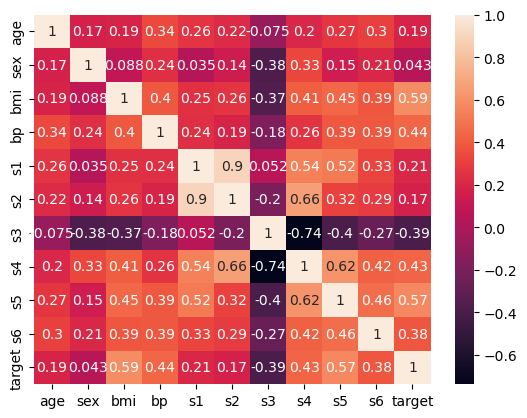

In [26]:
sns.heatmap(df.corr(), annot=True)

### 상관계수가 0.5 이상인 bmi, s5만 이상치 제거

In [27]:
bmi_outlier_index = get_outlier(df, 'bmi')

# bp_outlier_index = get_outlier(df, 'bp')
# bp_outlier_index = bp_outlier_index.insert(0, bmi_outlier_index)


# s1_outlier_index = get_outlier(df, 's1')
# s1_outlier_index = s1_outlier_index.insert(0, bp_outlier_index)


# s2_outlier_index = get_outlier(df, 's2')
# s2_outlier_index = s2_outlier_index.insert(0, s1_outlier_index)


# s3_outlier_index = get_outlier(df, 's3')
# s3_outlier_index = s3_outlier_index.insert(0, s2_outlier_index)


s4_outlier_index = get_outlier(df, 's4')
s4_outlier_index = s4_outlier_index.insert(0, bmi_outlier_index)


# s5_outlier_index = get_outlier(df, 's5')
# s5_outlier_index = s5_outlier_index.insert(0, s4_outlier_index)


# s6_outlier_index = get_outlier(df, 's6')
# s6_outlier_index = s6_outlier_index.insert(0, s5_outlier_index)


all_outlier_index = list(set(s4_outlier_index))
all_outlier_index = s4_outlier_index.to_list()
all_outlier_index

[256, 366, 367, 123, 322]

In [28]:
df.drop(all_outlier_index,inplace=True)
df = df.reset_index(drop=True)
df.tail()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
432,0.04171,0.05068,0.01966,0.05974,-0.00570,-0.00257,-0.02867,-0.00259,0.03119,0.00721,178.00000
433,-0.00551,0.05068,-0.01591,-0.06764,0.04934,0.07917,-0.02867,0.03431,-0.01811,0.04449,104.00000
434,0.04171,0.05068,-0.01591,0.01729,-0.03734,-0.01384,-0.02499,-0.01108,-0.04688,0.01549,132.00000
435,-0.04547,-0.04464,0.03906,0.00122,0.01632,0.01528,-0.02867,0.02656,0.04453,-0.02593,220.00000
436,-0.04547,-0.04464,-0.07303,-0.08141,0.08374,0.02781,0.17382,-0.03949,-0.00422,0.00306,57.00000


In [29]:
y = torch.tensor(df['target'].values.astype(np.float32))
x = torch.tensor(df.drop('target', axis = 1).values.astype(np.float32)) 

In [30]:
print(x.shape)
print(y.shape)

torch.Size([437, 10])
torch.Size([437])


In [31]:
y = torch.unsqueeze(y, 1)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)
    
model = LinearRegressionModel(9, 1)
model = LinearRegressionModel(x.size(1), 1)

In [33]:
learning_rate = 0.2
epochs = 1000
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(epochs + 1):

    pred = model(x)
    loss = F.mse_loss(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [34]:
print(loss)

for param in model.parameters():
    print(param)

tensor(3064.6003, grad_fn=<MseLossBackward0>)
Parameter containing:
tensor([[  41.7370,  -90.3370,  350.9673,  249.4842,   15.5080,  -25.3696,
         -187.0069,  151.9861,  308.6410,  146.6336]], requires_grad=True)
Parameter containing:
tensor([152.2283], requires_grad=True)
